In [4]:
%reset -f
### One needs to first run https://www.kaggle.com/left13/various-nets-densenet121-0-96-acc-full-set
### DenseNet121 N_FFT 256 - 23 EPOCHS - 0.96 ACC ON 20% TEST
from utils import *
import pickle

import os, math
import numpy as np
seed = 2018
np.random.seed(seed)

import librosa
from collections import Counter
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras import Model
from keras import backend as K
from keras.utils import np_utils
from keras.applications.densenet import DenseNet121

import logging
logger = logging.getLogger()
logger.propagate = False
logger.setLevel(logging.ERROR)
plt.rcParams['figure.figsize'] = [18, 12]

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/yannis/miniconda3/envs/wingbeats/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcuda.so.1: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [ ]:
valid_features_file = os.path.join(TEMP_DATADIR,'valid_features.dat')
valid_labels_file = os.path.join(TEMP_DATADIR, 'valid_labels.dat')
xtest_names_file = os.path.join(TEMP_DATADIR, 'xtest_names.dat')
ytest_names_file = os.path.join(TEMP_DATADIR, 'ytest_names.dat')
tsne_file = os.path.join(TEMP_DATADIR, 'tsne.dat')
mosquitos_csv_file = os.path.join(TEMP_DATADIR, 'mosquitos.csv')

In [ ]:
# XX = pickle.load(open(TEMP_DATADIR + valid_features_file, "rb"))
y = pickle.load(open(valid_labels_file, "rb"))

In [ ]:
# tsne = manifold.TSNE(n_components = 2, perplexity = 30, init='pca',random_state = seed, verbose = 1)
# X = tsne.fit_transform(np.vstack(XX))
# pickle.dump(X, open(TEMP_DATADIR + 'tsne.dat', "wb"))

X = pickle.load(open(tsne_file, "rb"))

In [3]:
x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)

NameError: name 'X' is not defined

In [11]:
def plot_tsne(y_label, y_color, dimX=10, dimY=8):
    fig = plt.figure(figsize = (dimX, dimY))
    ax = fig.gca()

    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], str(y_label[i]), color = plt.cm.tab20(y_color[i]), fontdict = {'weight': 'bold', 'size': 9})

    fig.suptitle('0: Ae. aegypti, 1: Ae. albopictus, 2: An. gambiae, 3: An. arabiensis, 4: C. pipiens, 5: C. quinquefasciatus')

    plt.show()

In [12]:
X_names = pickle.load(open(xtest_names_file, "rb"))
y_names = pickle.load(open(ytest_names_file, "rb"))

In [13]:
df = pd.read_csv(mosquitos_csv_file, delimiter=';', index_col=0)
#df['fname'] = df['index']
#df.drop('index',axis=1,inplace=True)
df.sample(4)

fname      pow0      pow1      pow2  \
176465  F170214_224511_028_G_050_T_25.9_H_71.1  0.124836  0.102571  0.016339   
84168                 F170207_120954_192_G_050  0.171112  0.029992  0.001557   
89796   F170228_141456_004_G_050_T_25.9_H_61.4  0.112485  0.078215  0.030090   
22566                 F170206_202503_020_G_050  0.045689  0.139331  0.010273   

               fr0          fr1          fr2  damping_0  damping_1  damping_2  \
176465  644.531250  1306.640625  1957.031250   0.038636   0.019058   0.014970   
84168   650.390625  1301.757812  1954.101562   0.033784   0.019505   0.016492   
89796   501.953125  1008.789062  1508.789062   0.045720   0.023717   0.016181   
22566   563.476562  1108.398438  1663.085938   0.043328   0.028634   0.008808   

                                                    names  pathlen  fnamelen  \
176465  /home/kalfasyan/data/insects/Wingbeats/C. pipi...       10         9   
84168   /home/kalfasyan/data/insects/Wingbeats/Ae. aeg...        9         5   
89796   /home/kalfasyan/data/insects/Wingbeats/Ae. alb...        9         9   
22566   /home/kalfasyan/data/insects/Wingbeats/Ae. aeg...        9         5   

        temp  humd           label  
176465  25.9  71.1      C. pipiens  
84168    NaN   NaN     Ae. aegypti  
89796   25.9  61.4  Ae. albopictus  
22566    NaN   NaN     Ae. aegypti

In [14]:
set_X_names = set(X_names)
idx_xnames = df.names.apply(lambda x: X_names[X_names.index(x)] if x in set_X_names else np.nan)
idx_y = df.names.apply(lambda x: y_names[X_names.index(x)] if x in set_X_names else np.nan)
df['idx_xnames'] = idx_xnames
df['idx_y'] = idx_y

df = df[~df.idx_xnames.isnull()]
df['X0'] = X[:,0]
df['X1'] = X[:,1]
df['date'] = df['fname'].apply(lambda x: pd.to_datetime(x.split('_')[0] + x.split('_')[1], format='F%y%m%d%H%M%S'))
df['date_days'] = df.date.dt.dayofyear#to_period('d').apply(lambda x: x.strftime('%Y%m%d'))
df['date_hours'] = df.date.dt.hour

# Original

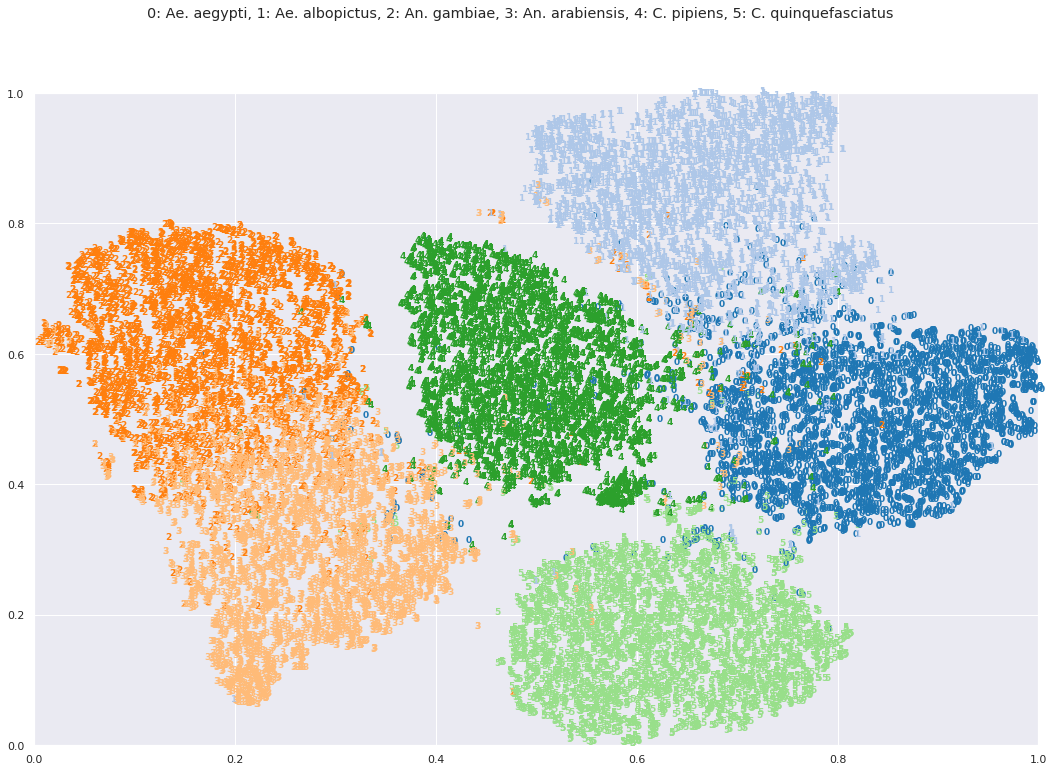

In [20]:
# %matplotlib widget

plot_tsne(y_label=y, y_color=y, dimX=18, dimY=12)

## Day of the year

In [21]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
lb.fit(df.date_days)
y_day = lb.transform(df.date_days)
pd.Series(y_day).value_counts()

50    2179
49    1681
36    1577
35    1367
27     766
26     763
23     700
22     689
28     686
8      637
24     596
10     557
20     543
15     536
9      529
21     521
29     485
25     481
16     473
14     438
5      433
7      423
6      411
30     396
1      387
34     380
18     361
17     339
11     315
13     305
31     288
32     259
38     258
4      244
39     232
41     210
2      188
19     155
40     150
0      149
42     143
46     139
12     131
45     124
3      123
43      95
44      78
48      76
37      64
33      63
47      37
dtype: int64

In [22]:
np.unique(y_day)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

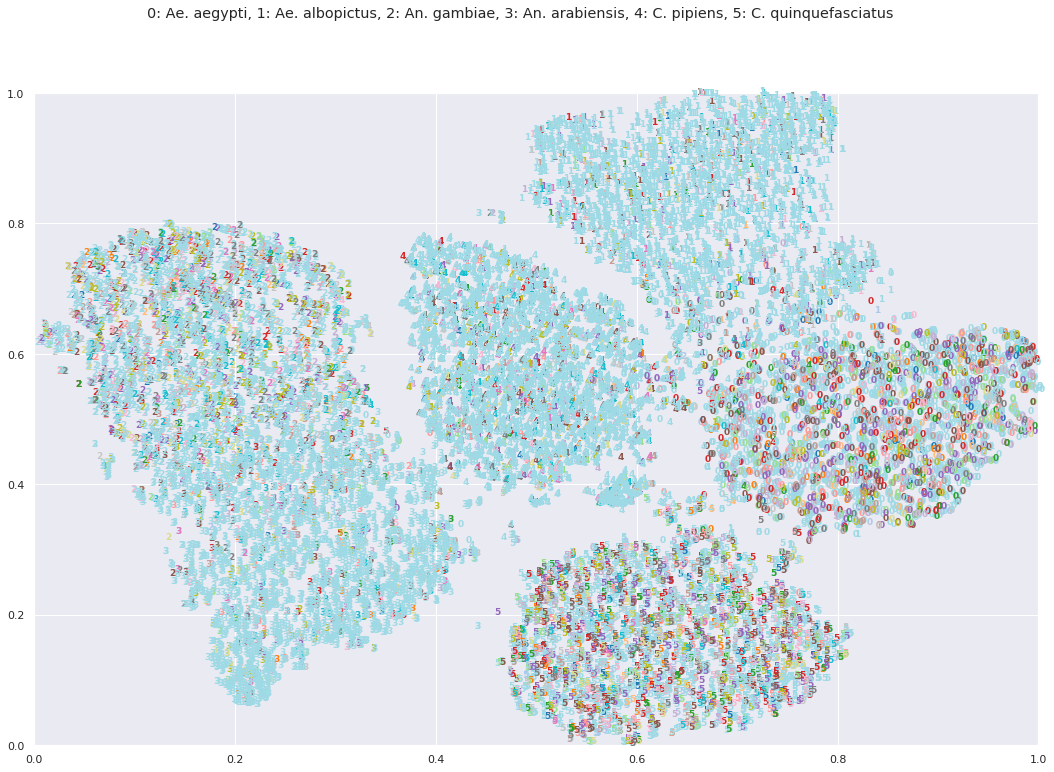

In [23]:
plot_tsne(y_color=y_day, y_label=y, dimX=18, dimY=12)

## Hour of the day

In [24]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
lb.fit(df.date_hours)
y_hour = lb.transform(df.date_hours)
pd.Series(y_hour).value_counts()

11    2543
23    1566
12    1462
19    1377
17    1366
20    1347
15    1344
16    1342
14    1332
18    1265
21    1160
13    1004
22     826
0      611
1      607
10     578
9      561
3      548
2      543
4      460
8      384
5      354
6      321
7      259
dtype: int64

In [25]:
(df.date_hours>=23).sum()

1566

In [26]:
y_specific_hour = list((df.date_hours >= 21 ) | (df.date_hours <= 6).tolist())

pd.Series(y_specific_hour).value_counts()

False    16164
True      6996
dtype: int64

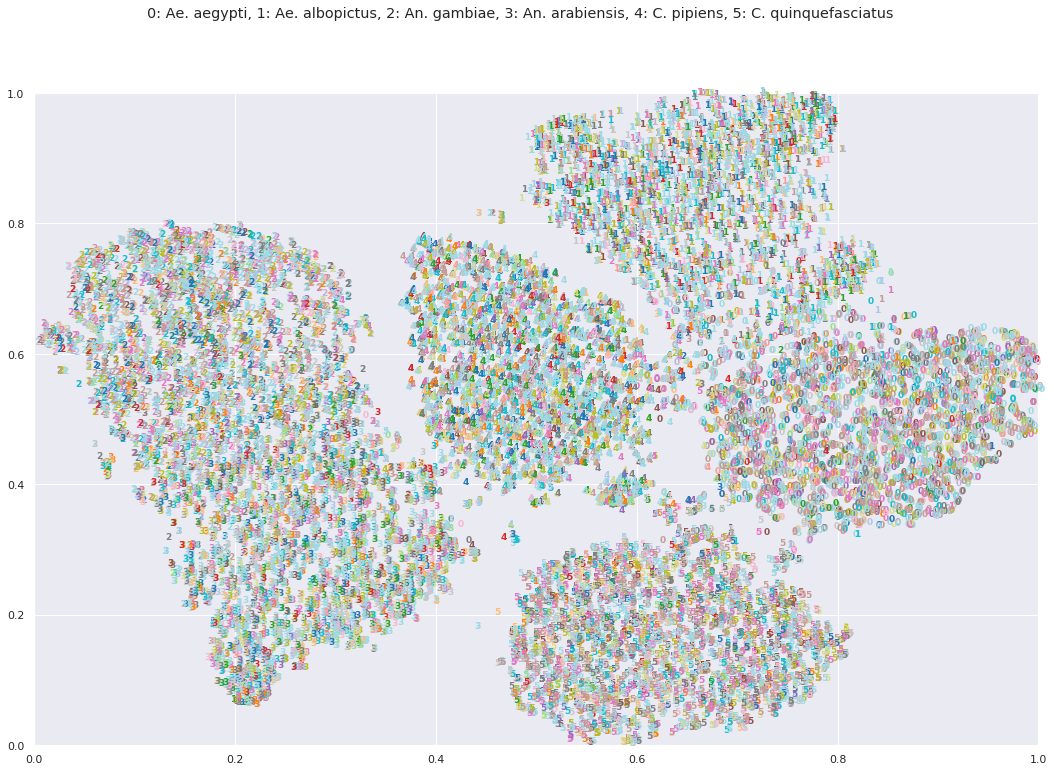

In [27]:
plot_tsne(y_color=y_hour, y_label=y, dimX=18, dimY=12)

## Month

In [28]:
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
lb.fit(df.date.dt.to_period('m'))

LabelEncoder()

In [29]:
y_month = list(lb.transform(df.date.dt.to_period('m')))

In [30]:
df.date.dt.to_period('m').value_counts()

2017-02    11285
2017-01     4832
2016-12     4236
2017-03     2807
Freq: M, Name: date, dtype: int64

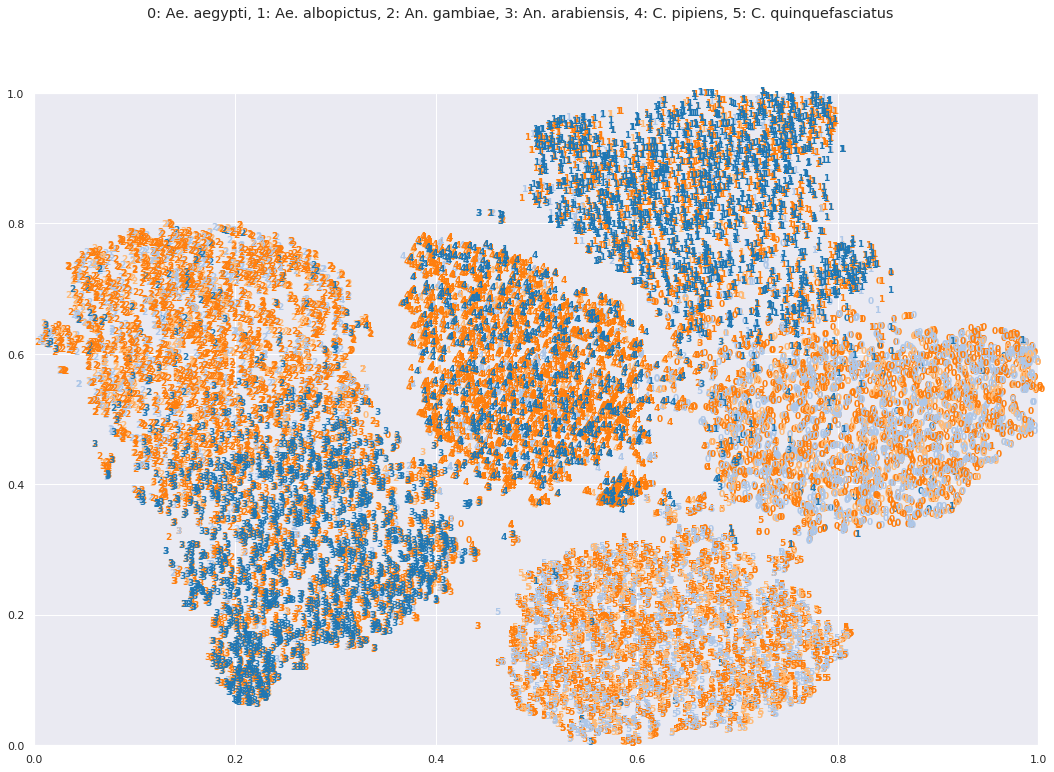

In [31]:
plot_tsne(y_color=y_month, y_label=y, dimX=18, dimY=12)

## Fundamental Frequency (threshold)

In [32]:
y_fr0 = (df.fr0 > 550).tolist()
pd.Series(y_fr0).value_counts()

True     14143
False     9017
dtype: int64

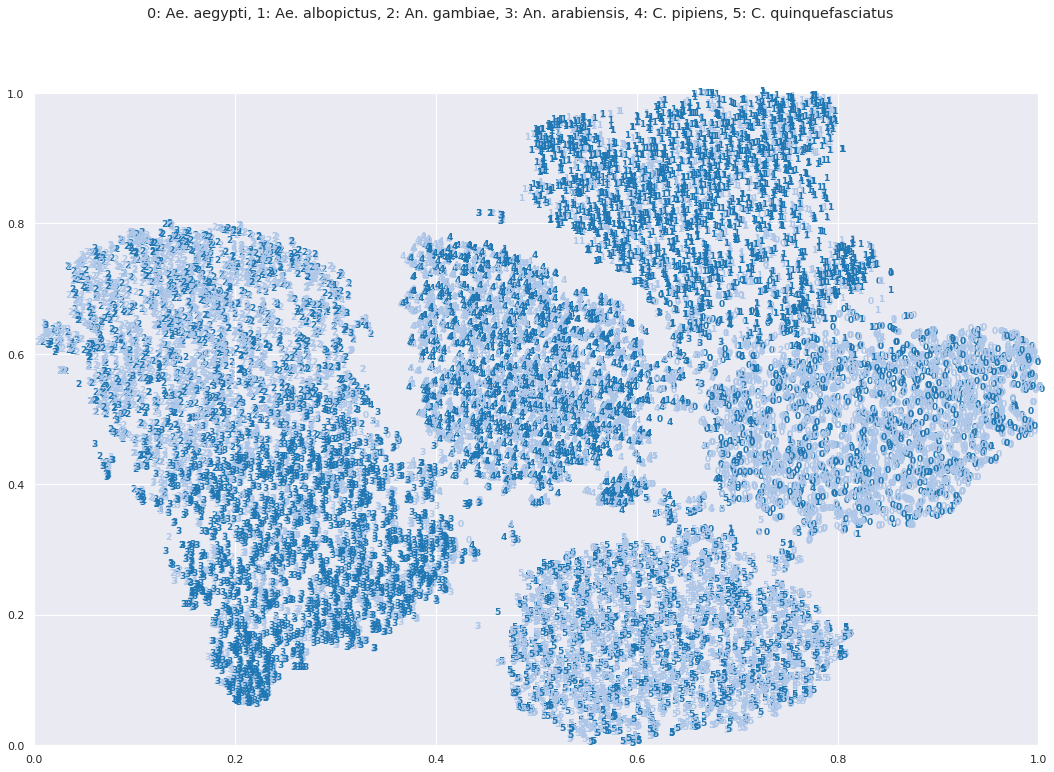

In [33]:
plot_tsne(y_color=y_fr0, y_label=y, dimX=18, dimY=12)

# **Selection from t-sne map**.

In [15]:
selection = (df['X0'] > 0.545) & (df['X0'] < 0.616) & (df['X1'] > 0.35) & (df['X1'] < 0.427)

xx = -0.12; yy = 0.18
selection2 = (df['X0'] > 0.545 + xx) & (df['X0'] < 0.616 + xx) & (df['X1'] > 0.35 + yy) & (df['X1'] < 0.427 + yy)

#small cluster mid
#(df['X0'] > 0.545) & (df['X0'] < 0.616) & (df['X1'] > 0.35) & (df['X1'] < 0.427)
#(df['X0'] > 0.05) & (df['X0'] < 0.36) & (df['X1'] > 0.05) & (df['X1'] < 0.8)

y_x0 = (selection).tolist()
y_x02 = (selection2).tolist()

## Selection 1

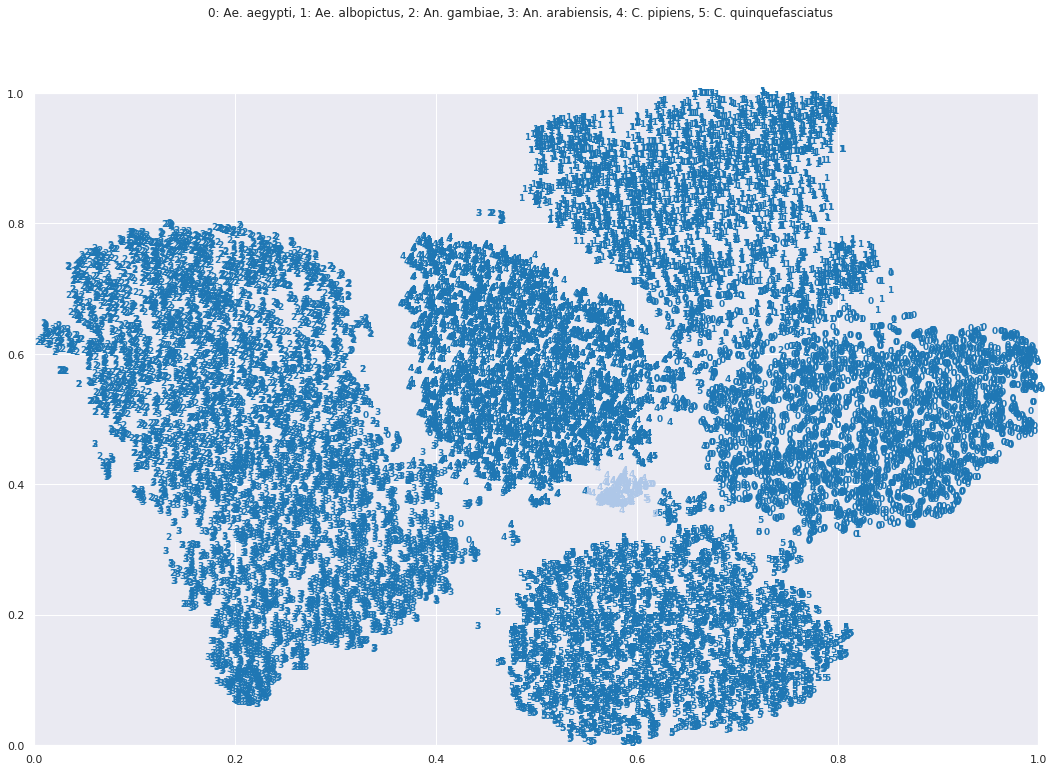

In [16]:
# %matplotlib inline
#widget
plot_tsne(y_color=y_x0, y_label=y, dimX=18, dimY=12)

## Selection 2

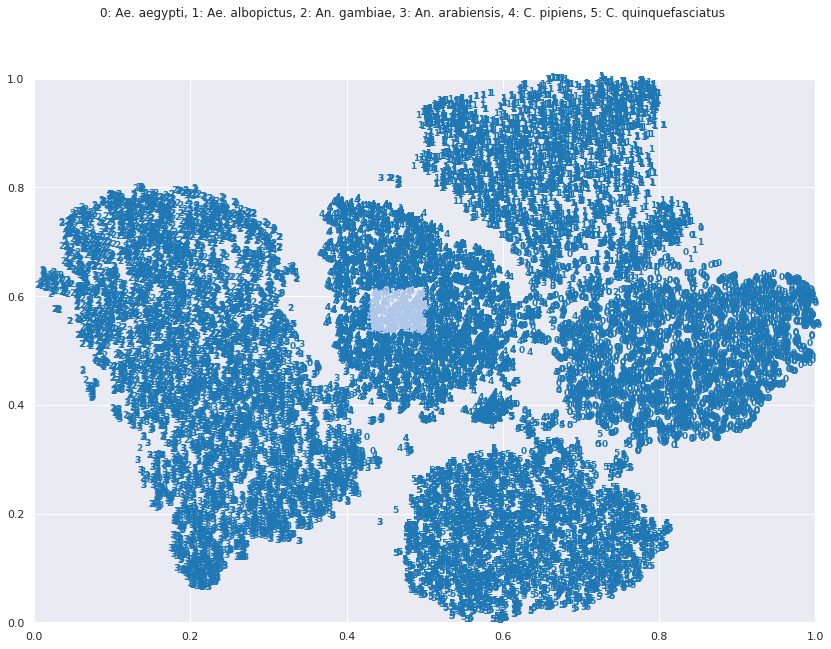

In [17]:
plot_tsne(y_color=y_x02, y_label=y, dimX=14, dimY=10)

# Analysis of "selection"

### What kind of insect classes are there

In [1]:
# selection = selection2

NameError: name 'selection2' is not defined

In [19]:
df[selection].idx_y.value_counts()

4.0    73
3.0    31
5.0    27
0.0    24
2.0    17
1.0    17
Name: idx_y, dtype: int64

In [20]:
from wavhandler import read_simple
X_sel, X_sel_names = read_simple(df[selection].names)
pd.Series(X_sel_names).apply(lambda x: x.split('/')[6]).value_counts()

C. pipiens             73
An. arabiensis         31
C. quinquefasciatus    27
Ae. aegypti            24
An. gambiae            17
Ae. albopictus         17
dtype: int64

### Random signal plot from selection

Text(0.5, 1.0, 'C. pipiens')

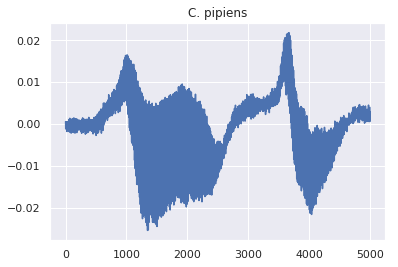

In [25]:
rdm = np.random.randint(0,188)
plt.figure()
plt.plot(X_sel[:,rdm])
plt.title(X_sel_names[rdm].split('/')[6])

### Histograms of signals collected per day for selection

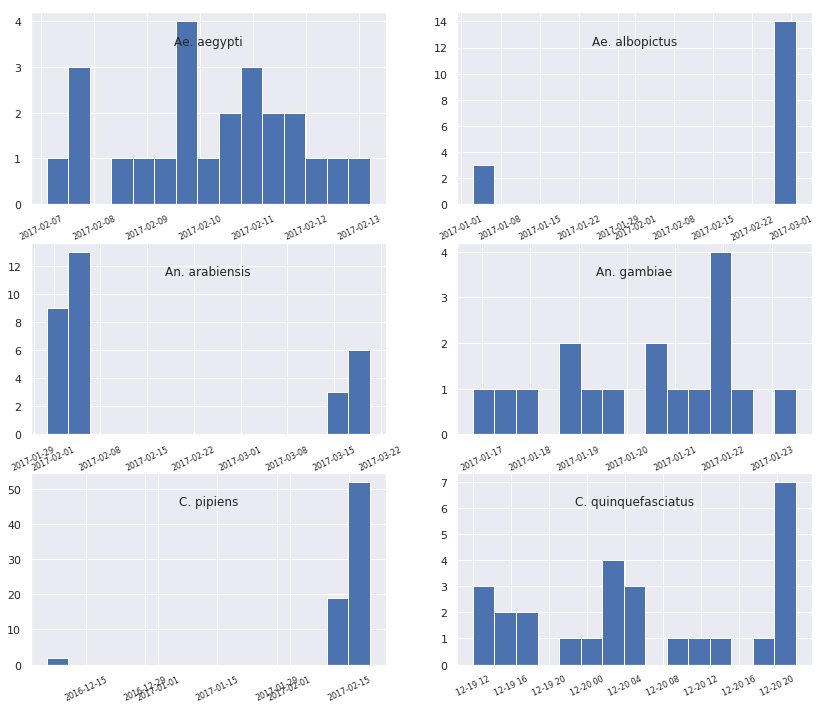

In [29]:
plt.figure(figsize=(14,12))
plt.tight_layout()
for i, (date,sub) in enumerate(df[selection][['label', 'date']].sort_values(by='label').groupby('label')):
    plt.subplot(3,2,i+1)
    sub.date.hist(bins=15, xrot=25, xlabelsize=8)
#     plt.ylim(0,20)
    plt.title(sub.label.unique().tolist()[0], y=0.8)

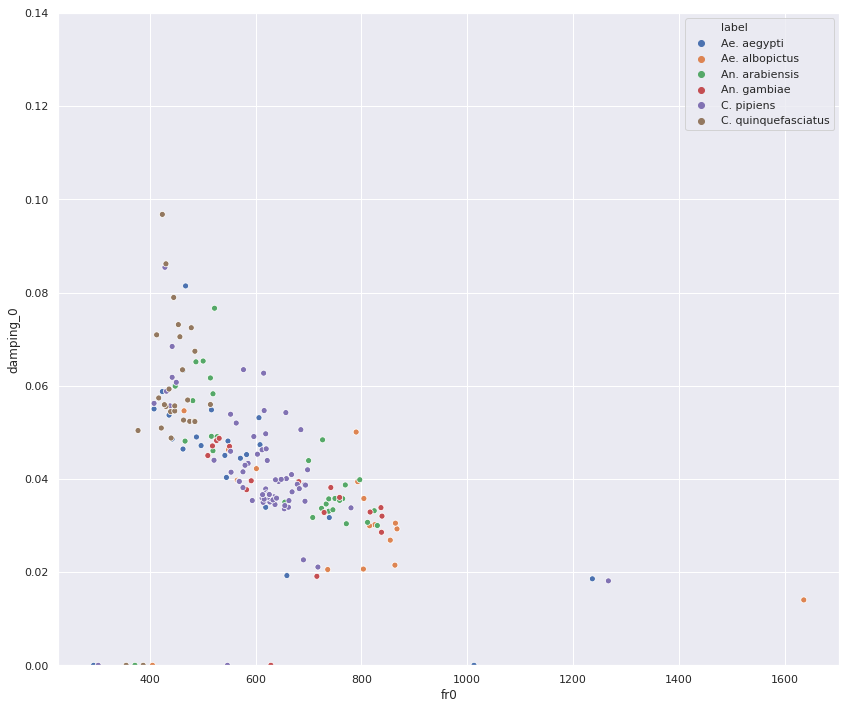

In [30]:
df['selection'] = selection
sub = df[selection][['label', 'fr0', 'damping_0', 'pow0', 'date_days', 'selection']].sort_values(by='label')

plt.figure(figsize=(14,12))
plt.ylim(0,0.14)
sns.scatterplot(data=sub, x='fr0', y='damping_0', 
                 hue='label', alpha=1.)#, palette=sns.color_palette("cubehelix"))

## PCA on selection

In [31]:
def perform_pca_on_matrix(X, y, daily_data=False):
#     idx = np.random.randint(X.shape[0], size=3000)
#     X = X[idx,:]
#     labelarray = y[idx]
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    X_std = StandardScaler(with_std=False).fit_transform(X);  # standardization of data
    if daily_data:
        y = pd.Series(y).apply(lambda x: periods.index(x))
    ncomps = 2
    pca = PCA(n_components=ncomps) # 10 to get 80% explained variance
    Χ_final = pca.fit_transform(X_std)
    print("EXPLAINED VARIANCE with {0:d} components: {1:.2f}".format(ncomps,pca.explained_variance_ratio_.sum()) )

    sns.scatterplot(Χ_final[:,0], Χ_final[:,1], alpha=0.6, hue=y, legend='full')#, palette=sns.color_palette("cubehelix"))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    
    df_pca = pd.DataFrame(pca.components_,index = ['PC-1','PC-2'])#, 'PC-3'])
    return df_pca

In [32]:
X = read_simple(df.names)[0]

EXPLAINED VARIANCE with 2 components: 0.21


0         1         2         3         4         5         6     \
PC-1 -0.000748 -0.000326 -0.001550 -0.001501 -0.000913 -0.000736 -0.001170   
PC-2  0.002810  0.002881  0.001859 -0.000284 -0.001076 -0.000238 -0.000318   

          7         8         9     ...      4990      4991      4992  \
PC-1 -0.000636 -0.000128 -0.000807  ... -0.002695 -0.002709 -0.000666   
PC-2  0.000858  0.000968 -0.000035  ... -0.002081 -0.001753 -0.000108   

          4993      4994      4995      4996      4997      4998      4999  
PC-1 -0.000843 -0.002332 -0.003074 -0.002707 -0.001068 -0.000135 -0.000853  
PC-2 -0.000143  0.000615  0.000026 -0.000631 -0.000273 -0.000502 -0.001495  

[2 rows x 5000 columns]

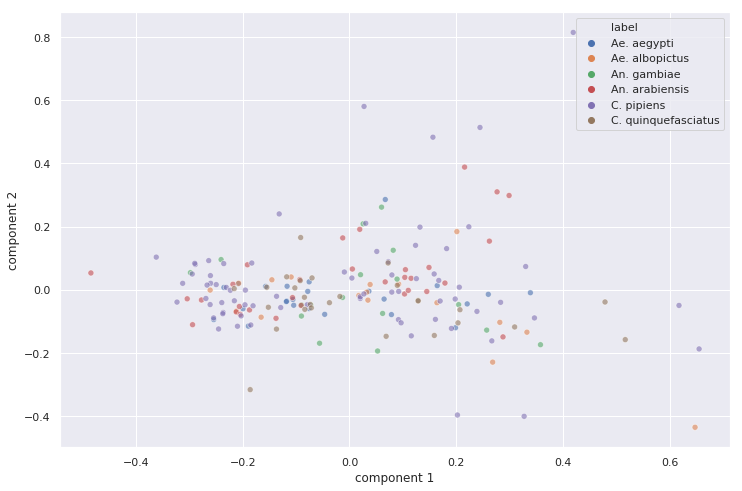

In [33]:
plt.figure(figsize=(12,8))
perform_pca_on_matrix(X_sel.T, df[selection]['label'])

# Comparison of 2 selections

In [34]:
df_sel = df[selection]
df_sel2 = df[selection2]

In [35]:
sel_pip = df_sel[df_sel.label=='C. pipiens'].drop(['pathlen', 'fnamelen','idx_y', 'X0','X1','selection'], axis=1)
sel_pip.describe()

pow0       pow1       pow2          fr0          fr1          fr2  \
count  73.000000  73.000000  73.000000    73.000000    73.000000    73.000000   
mean    0.112989   0.080496   0.009828   613.027076  1222.856914  1833.917487   
std     0.039757   0.047168   0.013204   111.483760   220.564384   324.529020   
min     0.000102   0.000039   0.000001   302.734375   710.937500  1212.890625   
25%     0.088688   0.036302   0.002823   577.148438  1159.179688  1735.351562   
50%     0.121873   0.079462   0.005412   620.117188  1237.304688  1854.492188   
75%     0.143223   0.113321   0.012869   654.296875  1296.875000  1939.453125   
max     0.168138   0.167906   0.098735  1266.601562  2531.250000  3775.390625   

       damping_0  damping_1  damping_2       temp       humd   date_days  \
count  73.000000  73.000000  73.000000  71.000000  71.000000   73.000000   
mean    0.040964   0.021525   0.013260  25.752113  67.461972   54.547945   
std     0.012799   0.007208   0.006253   0.311154   6.301097   48.276703   
min     0.000000   0.000000   0.000000  24.500000  47.200000   44.000000   
25%     0.035658   0.018547   0.009076  25.900000  63.800000   45.000000   
50%     0.038678   0.021071   0.013674  25.900000  67.700000   46.000000   
75%     0.045936   0.025226   0.017267  25.900000  72.100000   48.000000   
max     0.085421   0.042051   0.027972  25.900000  77.500000  340.000000   

       date_hours  
count   73.000000  
mean    15.287671  
std      7.281025  
min      1.000000  
25%     14.000000  
50%     18.000000  
75%     21.000000  
max     23.000000

In [36]:
sel2_pip = df_sel2[df_sel2.label=='C. pipiens'].drop(['pathlen', 'fnamelen','idx_y', 'X0','X1','selection'], axis=1)
sel2_pip.describe()

pow0        pow1          pow2          fr0          fr1  \
count  107.000000  107.000000  1.070000e+02   107.000000   107.000000   
mean     0.107114    0.074762  7.172766e-03   608.471452  1216.158002   
std      0.048015    0.050772  7.117852e-03   147.315944   290.606048   
min      0.000023    0.000013  1.067223e-07   279.296875   677.734375   
25%      0.077397    0.028047  2.322170e-03   570.800781  1136.718750   
50%      0.120948    0.072649  5.126334e-03   611.328125  1211.914062   
75%      0.145796    0.123038  9.893759e-03   646.484375  1287.109375   
max      0.172302    0.162040  3.905556e-02  1330.078125  2661.132812   

               fr2   damping_0   damping_1   damping_2       temp       humd  \
count   107.000000  107.000000  107.000000  107.000000  96.000000  96.000000   
mean   1825.651650    0.039746    0.019990    0.011576  25.688542  66.860417   
std     427.353814    0.014247    0.009190    0.007088   0.323100   7.314333   
min     954.101562    0.000000    0.000000    0.000000  25.200000  43.800000   
25%    1709.960938    0.035935    0.017875    0.007628  25.200000  63.300000   
50%    1835.937500    0.038633    0.020614    0.013347  25.900000  67.700000   
75%    1922.851562    0.046069    0.025919    0.016340  25.900000  71.600000   
max    3920.898438    0.090805    0.042491    0.024892  25.900000  79.400000   

        date_days  date_hours  
count  107.000000  107.000000  
mean    76.672897   14.046729  
std     89.727657    7.642215  
min     44.000000    0.000000  
25%     45.000000    7.000000  
50%     46.000000   17.000000  
75%     49.000000   20.000000  
max    341.000000   23.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f780f921588>,
      dtype=object)

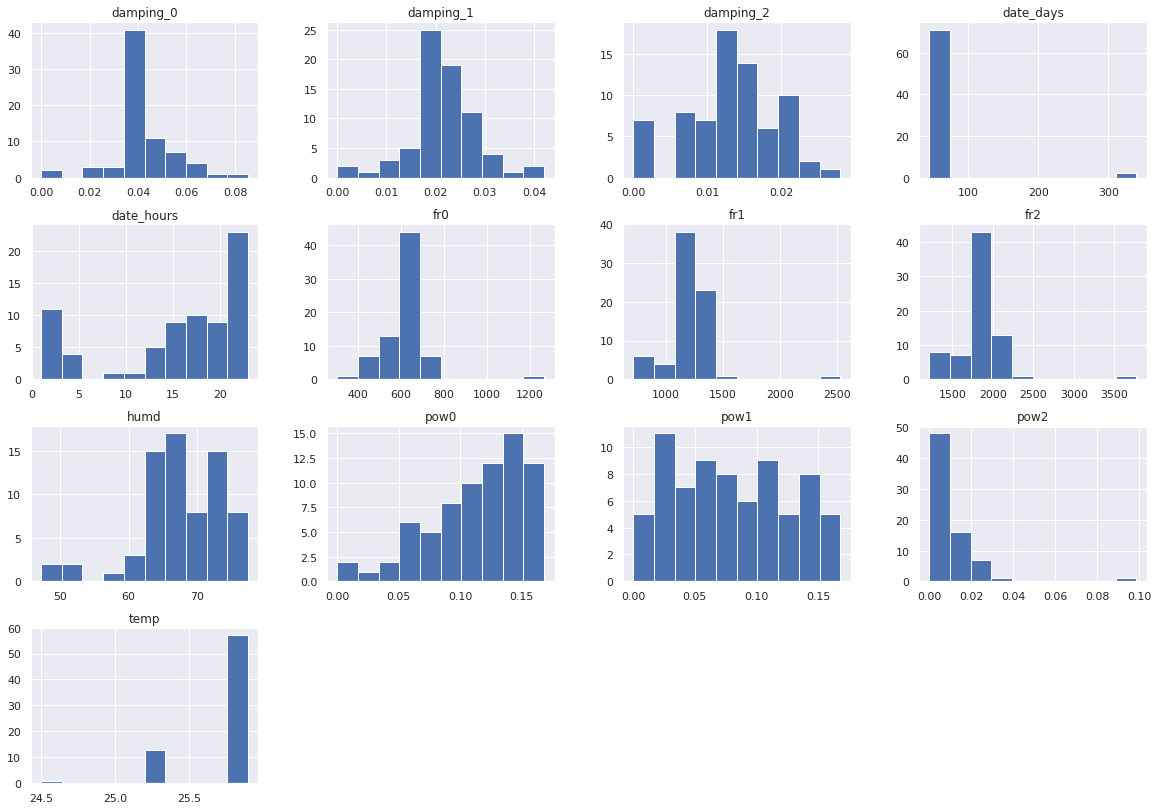

In [37]:
sel_pip.hist(figsize=(20,14))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f77d7f976d8>,
      dtype=object)

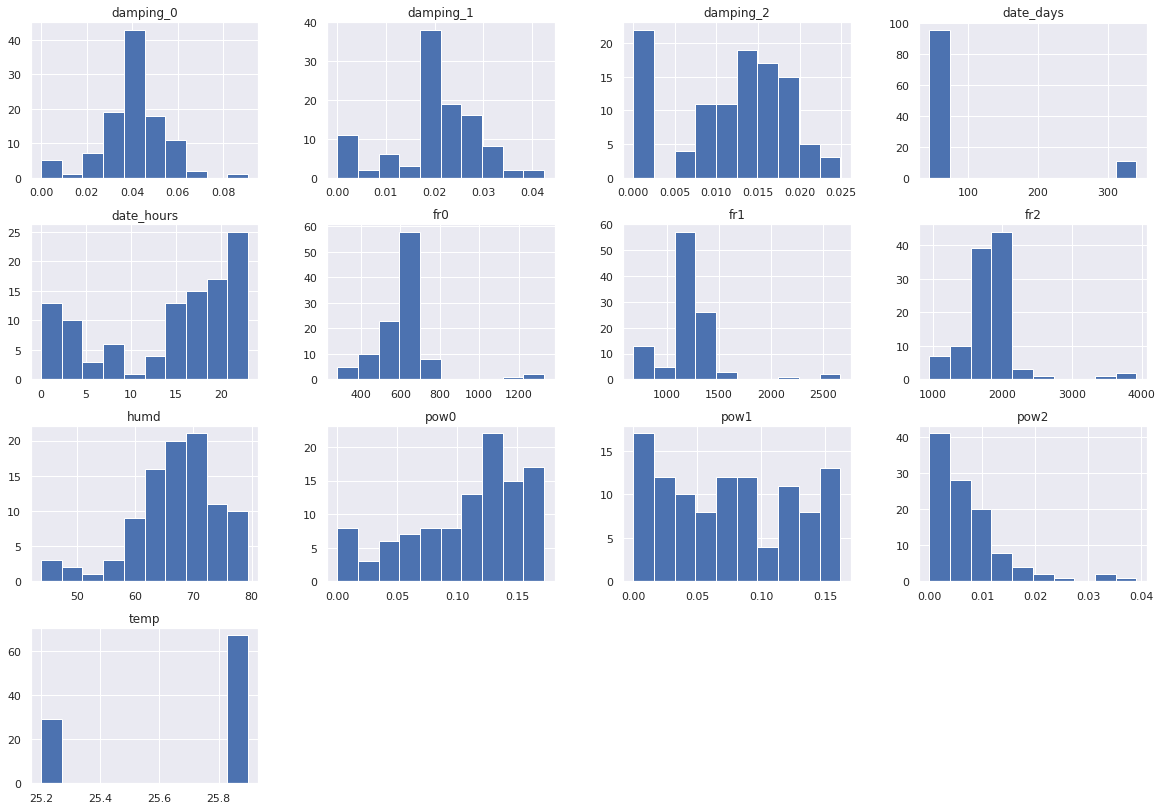

In [38]:
sel2_pip.hist(figsize=(20,14))

## Distance matrices

In [39]:
def upper_triangular(a, metric='cosine'):
    from scipy.spatial.distance import pdist, squareform
    dist_mat = squareform(pdist(a.T, metric=metric))
    up_tr = dist_mat[np.triu_indices(len(dist_mat))]
    return up_tr, dist_mat

In [40]:
from wavhandler import transform_data

Xsel, X_sel_names = read_simple(sel_pip.names)
Xsel2, X_sel2_names = read_simple(sel2_pip.names)

Xsel = transform_data(Xsel.T)
Xsel2 = transform_data(Xsel2.T)

100%|██████████| 107/107 [00:00<00:00, 1690.14it/s]


In [41]:
mtr = 'euclidean'
idx = np.random.randint(0, Xsel2.shape[0], size=Xsel.shape[0])
np.corrcoef(upper_triangular(Xsel, metric=mtr)[0], upper_triangular(Xsel2[idx,:], metric=mtr)[0])

array([[1.        , 0.96172038],
       [0.96172038, 1.        ]])

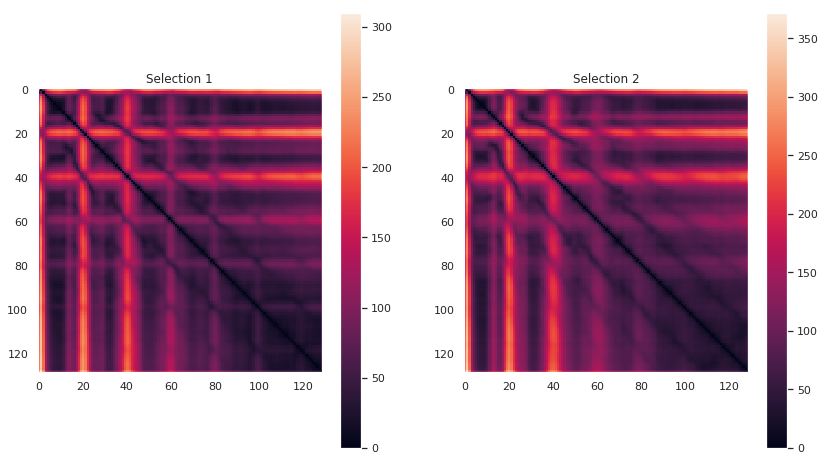

In [42]:
plt.figure(figsize=(14,8)); plt.tight_layout();
plt.subplot(1,2,1); plt.title('Selection 1')
plt.imshow(upper_triangular(Xsel, metric=mtr)[1])
plt.colorbar()
plt.grid(False)
plt.subplot(1,2,2); plt.title('Selection 2')
plt.imshow(upper_triangular(Xsel2, metric=mtr)[1])
plt.colorbar()
plt.grid(False)

## Varriability within classes

In [43]:
df[df.label == 'C. pipiens'].describe()

pow0         pow1          pow2          fr0          fr1  \
count  3859.000000  3855.000000  3.844000e+03  3859.000000  3855.000000   
mean      0.104715     0.076705  8.281881e-03   620.385685  1247.229400   
std       0.050021     0.049410  9.596236e-03   138.306241   270.898364   
min       0.000006     0.000009  4.209006e-08   269.531250   623.046875   
25%       0.068212     0.034302  2.401124e-03   576.171875  1168.945312   
50%       0.114516     0.072422  5.331025e-03   620.117188  1242.187500   
75%       0.147564     0.120878  1.096708e-02   651.367188  1303.710938   
max       0.175292     0.170948  1.549118e-01  1473.632812  2907.226562   

               fr2    damping_0    damping_1    damping_2      pathlen  \
count  3844.000000  3859.000000  3855.000000  3844.000000  3860.000000   
mean   1864.489759     0.038021     0.019933     0.012467     9.931865   
std     390.878306     0.014239     0.007697     0.006701     0.252010   
min     954.101562     0.000000     0.000000     0.000000     9.000000   
25%    1750.732422     0.034639     0.017814     0.008633    10.000000   
50%    1862.304688     0.037943     0.020032     0.013663    10.000000   
75%    1954.101562     0.044093     0.023984     0.016761    10.000000   
max    3999.023438     0.108295     0.056760     0.038688    10.000000   

          fnamelen         temp         humd   idx_y           X0  \
count  3860.000000  3597.000000  3597.000000  3860.0  3860.000000   
mean      8.727461    25.729135    67.329552     4.0     0.426151   
std       1.008038     0.305669     6.559226     0.0     0.196994   
min       5.000000    24.500000    39.400000     4.0     0.006880   
25%       9.000000    25.900000    63.800000     4.0     0.248477   
50%       9.000000    25.900000    67.700000     4.0     0.440868   
75%       9.000000    25.900000    72.100000     4.0     0.573603   
max       9.000000    25.900000    80.400000     4.0     0.969386   

                X1    date_days   date_hours  
count  3860.000000  3860.000000  3860.000000  
mean      0.573408    66.434974    13.559845  
std       0.210303    74.147851     7.637030  
min       0.060392    44.000000     0.000000  
25%       0.429855    45.000000     5.000000  
50%       0.579158    46.000000    16.000000  
75%       0.722896    48.000000    20.000000  
max       0.997297   341.000000    23.000000

In [44]:
df[df.label == 'C. quinquefasciatus'].describe()

pow0         pow1         pow2          fr0          fr1  \
count  3860.000000  3855.000000  3850.000000  3860.000000  3855.000000   
mean      0.099240     0.077364     0.006659   460.238221   919.851198   
std       0.040753     0.044261     0.007660    85.186284   167.863144   
min       0.000009     0.000009     0.000013   237.304688   583.984375   
25%       0.072905     0.041741     0.002542   428.710938   852.539062   
50%       0.104040     0.078063     0.004890   450.195312   896.484375   
75%       0.130635     0.113495     0.008376   469.970703   936.035156   
max       0.176049     0.171406     0.137909  1550.781250  3099.609375   

               fr2    damping_0    damping_1    damping_2  pathlen  fnamelen  \
count  3850.000000  3860.000000  3855.000000  3850.000000   3860.0    3860.0   
mean   1374.994420     0.054545     0.027226     0.015982      9.0       5.0   
std     240.554918     0.016951     0.010240     0.008748      0.0       0.0   
min     886.718750     0.000000     0.000000     0.000000      9.0       5.0   
25%    1276.367188     0.048491     0.020011     0.011119      9.0       5.0   
50%    1339.843750     0.055441     0.028403     0.016351      9.0       5.0   
75%    1398.437500     0.063859     0.033934     0.022285      9.0       5.0   
max    3116.210938     0.136000     0.057339     0.039596      9.0       5.0   

       temp  humd   idx_y           X0           X1    date_days   date_hours  
count   0.0   0.0  3860.0  3860.000000  3860.000000  3860.000000  3860.000000  
mean    NaN   NaN     5.0     0.470054     0.564143   354.564508    13.583161  
std     NaN   NaN     0.0     0.200659     0.268932     0.495886     6.770749  
min     NaN   NaN     5.0     0.008261     0.059828   354.000000     0.000000  
25%     NaN   NaN     5.0     0.283874     0.318742   354.000000     9.000000  
50%     NaN   NaN     5.0     0.492818     0.567714   355.000000    15.000000  
75%     NaN   NaN     5.0     0.647759     0.812337   355.000000    19.000000  
max     NaN   NaN     5.0     0.980428     1.000000   355.000000    23.000000